In [166]:
# Import required libraries
import pandas as pd
import numpy as np
import re
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV 
import matplotlib.pyplot as plt
import seaborn as sns

#Filepaths
home = '~/Downloads/urap_conflict_india/'
data = home + 'data/'

## Data

In [95]:
# Import dataset
events = pd.read_excel(data + 'combined_events.xlsx')
events.head(5)

,description,id_satp,relevant_event,multiple_events,internal_conflict,number_casualties,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism,note
0,A Communist Party of India-Maoist (CPI-Maoist)...,ID_6103,1,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,Communist Party of India-Maoist (CPI-Maoist) m...,ID_4707,1,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN
2,Senior separatist leaders Syed Ali Shah Geelan...,ID_94982,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Opposing Government of Indias (GoI) reported d...,ID_17777,1,0.0,1.0,905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
4,Cadres of the Communist Party of India-Maoist ...,ID_60843,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN


In [96]:
events.shape

(1084, 16)

In [97]:
events.describe()

,relevant_event,multiple_events,internal_conflict,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism
count,1084.000000,815.000000,812.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,612.000000,343.000000
mean,0.677122,0.100613,0.945813,3.810458,0.098039,0.050654,0.155229,0.044118,0.016340,0.331699,0.068627,0.093294
std,0.467792,0.301001,0.226526,57.089501,0.297611,0.219469,0.362419,0.205524,0.126883,0.471209,0.253026,0.291270
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,999.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## Preprocessing

In [98]:
# Function for processing text
def nlp_pipeline(data):
    # Convert to lower case
    data['description'] = data['description'].str.lower()
    # Remove duplicate values
    data = data.drop_duplicates().reset_index(drop=True)
    row_lst = []
    lem = WordNetLemmatizer()
    stop = stopwords.words('english')
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        # Remove non-alphanumeric characters
        row = re.sub(r'[^0-9A-Za-z]',  ' ', row)
        # Remove stopwords and lemmatizing
        row = ' '.join([lem.lemmatize(word) for word in row.split() if not word in set(stopwords.words('english'))])
        row_lst.append(row)
    data['description'] = row_lst
    return data

# Function for removing additional words
def remove_words(data, words_to_remove):
    row_lst = []
    for i in range(len(data)):
        row = str(data['description'].iloc[i])
        for word in words_to_remove:
            row = re.sub(word, '', row)
        row_lst.append(row)
    data['description'] = row_lst
    return data

In [99]:
# Clean data
cleaned_events = nlp_pipeline(events)
cleaned_events.head(5)

,description,id_satp,relevant_event,multiple_events,internal_conflict,number_casualties,number_injuries,pacification_event,economic_conditions,political_demands,communal_conflict,caste_conflict,naxalite_maoist,organized_crime,islamic_terrorism,note
0,communist party india maoist cpi maoist comman...,ID_6103,1,0.0,1.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,NaN
1,communist party india maoist cpi maoist militi...,ID_4707,1,1.0,1.0,0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN,NaN
2,senior separatist leader syed ali shah geelani...,ID_94982,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,opposing government india goi reported decisio...,ID_17777,1,0.0,1.0,905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN
4,cadre communist party india maoist cpi maoist ...,ID_60843,1,0.0,1.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN


## `relevant_event`

### Cross-Validation

**Define Functions**

In [147]:
# Define function to compute precision and recall
def binary_model_evaluation(true_y, predicted_y):
    # Find the confusion matrix
    cm = confusion_matrix(true_y, predicted_y)
    # Find relevant values
    fp = cm[0, 1]
    tp = cm[1, 1]
    fn = cm[1, 0]
    # How many relevant events are accurately identified?
    recall = tp / (tp + fn)
    # How many events identified as relevant are actually relevant?
    precision = tp / (tp + fp)
    return recall, precision

# Define function for cross-validation
def cross_validation(kernel, C, gamma, num_features, folds):
    # Split dataset into folds
    kf = KFold(n_splits=folds, shuffle=True)
    accuracy, recall, precision = [], [], []
    # SVM model
    SVM = svm.SVC(C=C, kernel=kernel, degree=3, gamma=gamma)
    vectorizer_tf = TfidfVectorizer(max_features=num_features)
    encoder = LabelEncoder()
    X = vectorizer_tf.fit_transform(cleaned_events['description']).toarray()
    X_scaled = preprocessing.scale(X)
    Y = encoder.fit_transform(cleaned_events['relevant_event'])
    # Cross-validation
    for train_idx, valid_idx in kf.split(X):
        # Training
        split_X_train, split_X_valid = X_scaled[train_idx, :], X_scaled[valid_idx, :]
        split_Y_train, split_Y_valid = Y[train_idx], Y[valid_idx]
        SVM.fit(split_X_train,split_Y_train)
        # Prediction
        predictions_SVM = SVM.predict(split_X_valid)
        # Evaluation
        accuracy.append(accuracy_score(predictions_SVM, split_Y_valid))
        metrics = binary_model_evaluation(split_Y_valid, predictions_SVM)
        recall.append(metrics[0])
        precision.append(metrics[1])
    return np.mean(accuracy), np.std(accuracy), np.mean(recall), np.mean(precision)

# Define function for cross-validation based on number of features
def num_features_cv(min_num_features, max_num_features, interval, kernel, C, gamma):
    num_features = np.array(range(min_num_features, max_num_features, interval))
    folds = np.array(range(2, 6))
    accuracy_cv = pd.DataFrame(columns = ['num_features', 'average_cv_accuracy', 'sd_cv_accuracy', 'average_recall', 'average_precision'])
    for n in num_features:
        mean, sd, recall, precision = cross_validation(kernel, C, gamma, n, 5) # Keeping features constant at 5
        accuracy_cv = accuracy_cv.append({'num_features': n, 'average_cv_accuracy': mean, 'sd_cv_accuracy': sd, 'average_recall': recall, 'average_precision': precision}, ignore_index=True)
    grouped_features = accuracy_cv.groupby('num_features').mean().sort_values(by='average_cv_accuracy', ascending=False).reset_index()
    return accuracy_cv, grouped_features

# Define function for plotting accuracy
def plot_accuracy(data):
    fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 9))
    sns.regplot(x='num_features', y='average_cv_accuracy', data=data, ax=ax[0,0])
    sns.regplot(x='num_features', y='sd_cv_accuracy', data=data, ax=ax[0,1])
    sns.regplot(x='num_features', y='average_recall', data=data, ax=ax[1,0])
    sns.regplot(x='num_features', y='average_precision', data=data, ax=ax[1,1])
    plt.show()

#### 1. Number of Features

First, I'm doing cross-validation to identify the optimal number of features to use in the model. I'm using a linear kernel for now.

In [121]:
# CV for number of features for whole range
accuracy_linear_full, grouped_linear_full = num_features_cv(1, 3001, 10, 'linear', 1.0, 'auto')

In [104]:
grouped_linear_full.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy,average_recall,average_precision
0,31.0,0.798070,0.018525,0.873770,0.837746
1,21.0,0.789492,0.008745,0.878180,0.824226
2,41.0,0.782632,0.023822,0.865394,0.825031
3,1181.0,0.778502,0.017879,0.869627,0.816445
4,2091.0,0.778186,0.019146,0.891959,0.803853


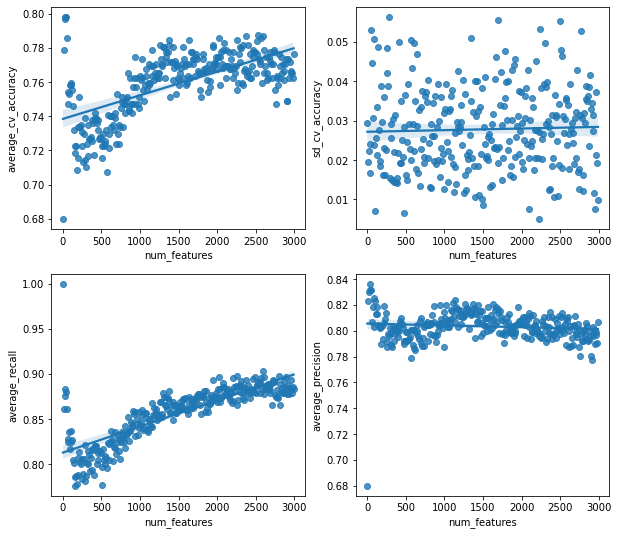

In [148]:
# Plot accuracy for CV on full range
plot_accuracy(grouped_linear_full)

In [106]:
# CV for number of features for 30-100
accuracy_linear_small, grouped_linear_small = num_features_cv(30, 101, 1, 'linear', 1.0, 'auto')

In [107]:
grouped_linear_small.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy,average_recall,average_precision
0,32.0,0.801496,0.025147,0.876454,0.838659
1,34.0,0.798412,0.022088,0.880671,0.833425
2,30.0,0.797386,0.017154,0.874940,0.835686
3,31.0,0.796021,0.023069,0.869484,0.836505
4,35.0,0.795664,0.017139,0.880445,0.830450


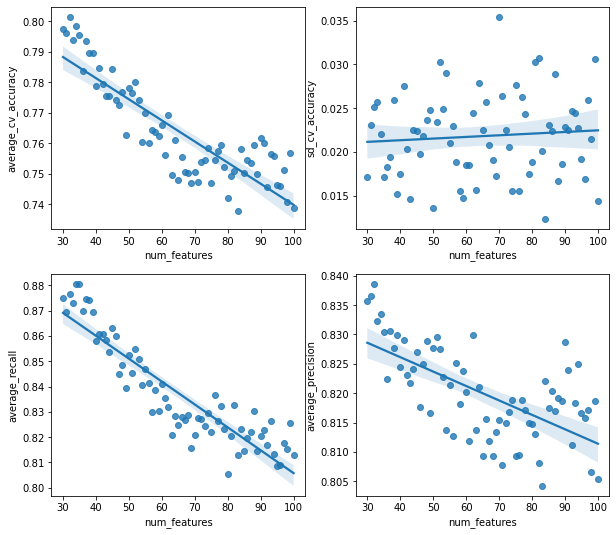

In [150]:
# Plot accuracy for CV on restricted range
plot_accuracy(grouped_linear_small)

- All measures of accuracy - average accuracy, recall and precision - are maximized at around 30.

#### 2. Kernel type

Next, I'm repeating the cross-validation using the RBF kernel (as opposed to the linear kernel used in the previous section).

In [151]:
# CV for number of features for whole range
accuracy_rbf_full, grouped_rbf_full = num_features_cv(1, 3001, 10, 'rbf', 1.0, 'auto')

In [152]:
grouped_rbf_full.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy,average_recall,average_precision
0,51.0,0.803628,0.039775,0.890128,0.832878
1,111.0,0.803562,0.022471,0.891237,0.832687
2,31.0,0.800897,0.031196,0.897368,0.826208
3,101.0,0.795361,0.038068,0.878656,0.831481
4,41.0,0.795352,0.029724,0.889146,0.823980


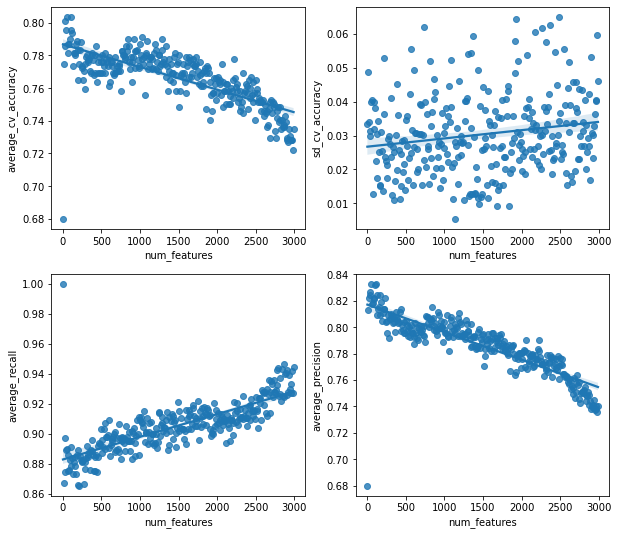

In [153]:
# Plot accuracy for CV on full range of features
plot_accuracy(grouped_rbf_full)

In [154]:
# CV for number of features for 30-100
accuracy_rbf_small, grouped_rbf_small = num_features_cv(30, 101, 1, 'rbf', 1.0, 'auto')

In [155]:
grouped_rbf_small.head(5)

,num_features,average_cv_accuracy,sd_cv_accuracy,average_recall,average_precision
0,34.0,0.818621,0.025961,0.887529,0.850051
1,33.0,0.813179,0.020117,0.894887,0.840539
2,32.0,0.811847,0.020310,0.891874,0.841980
3,36.0,0.809107,0.051881,0.891255,0.835635
4,30.0,0.809051,0.013512,0.890964,0.837791


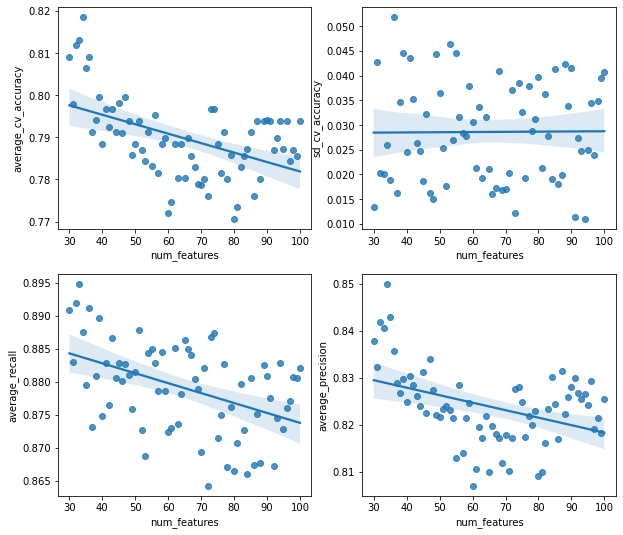

In [156]:
# Plot accuracy for CV on restricted range
plot_accuracy(grouped_rbf_small)

- Same as before - all measures of accuracy are maximized at around 30.
- CV doesn't show a significant difference between RBF and linear kernels but RBF is considered better so I'll go with that (plus test accuracy is higher with RBF).
- CV shows that 32 is the ideal number of features.

## Use the Model

**Prepare the Data**

In [451]:
# Vectorize the data using TFIDF
vectorizer_tf = TfidfVectorizer(max_features=32)
tf = vectorizer_tf.fit_transform(cleaned_events['description'])
tf_scaled = preprocessing.scale(tf.toarray())

In [452]:
# Features selected by TFIDF
vectorizer_tf.vocabulary_

{'communist': 6,
 'party': 20,
 'india': 13,
 'maoist': 15,
 'cpi': 7,
 'cadre': 4,
 'arrested': 3,
 'district': 8,
 'report': 24,
 'said': 25,
 'identified': 12,
 'village': 31,
 'security': 26,
 'force': 9,
 'police': 22,
 'area': 2,
 'recovered': 23,
 'two': 30,
 'government': 10,
 'three': 29,
 'militant': 16,
 'group': 11,
 'chief': 5,
 'minister': 17,
 'state': 27,
 'terrorist': 28,
 'according': 0,
 'one': 19,
 'also': 1,
 'national': 18,
 'killed': 14,
 'people': 21}

- Remove some words?

In [462]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(tf_scaled, cleaned_events['relevant_event'], test_size=0.15, random_state=42)

In [463]:
# Label encoding - transform the outcome variable to a suitable format for classification
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.fit_transform(y_test)

**Hyperparameter Tuning**

In [464]:
# Use grid search to find optimal values for C and gamma, using overall accuracy as the evaluation method
param_grid = {'C': np.arange(1, 10), 'gamma': [1, 0.1, 0.01, 0.001, 0.001]}
grid = GridSearchCV(svm.SVC(), param_grid, scoring='accuracy', refit=True, verbose=0)
grid.fit(X_train, y_train);
grid.best_params_

{'C': 1, 'gamma': 0.01}

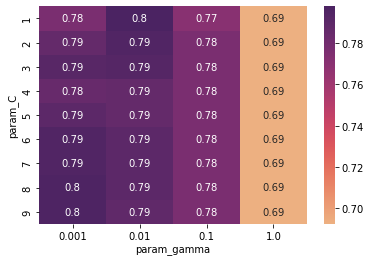

In [465]:
# Plot accuracy
df=pd.DataFrame(grid.cv_results_).pivot_table(index='param_C', columns='param_gamma', values='mean_test_score')
sns.heatmap(a, annot=True, cmap='flare');

- (1, 0.01), (8, 0.001) and (9, 0.001) have the highest accuracy. When I use it on the testing data, the accuracy is maximized with (1, 0.01).

**Training and Prediction**

In [466]:
# Train the SVM model and use it for prediction
SVM = svm.SVC(C=1, kernel='rbf', degree=1, gamma=0.01)
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print("Test accuracy:", accuracy_score(predictions_SVM, y_test)*100)

Test accuracy: 90.9090909090909


- The percentage of the data used for testing/training also affects accuracy. 15% seems to be the ideal percentage.

## Model Evaluation

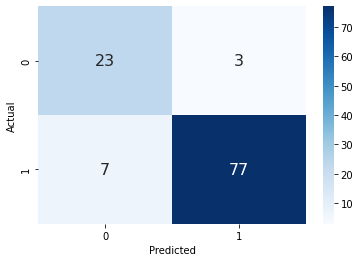

In [467]:
# Confusion matrix to show false positives and negatives
cm = confusion_matrix(y_test, predictions_SVM)
sns.heatmap(cm, annot=True, fmt = 'd', cmap = 'Blues', annot_kws = {'size': 16})
plt.xlabel('Predicted')
plt.ylabel('Actual');

In [468]:
# Computing prediciton and recall
fp = cm[0, 1]
tp = cm[1, 1]
fn = cm[1, 0]
tn = cm[0, 0]
total = fp + tp + fn + tn
# How many relevant events are accurately identified?
recall = tp / (tp + fn)
# How many events identified as relevant are actually relevant?
precision = tp / (tp + fp)

print('False positives:', fp)
print('True positives:', tp)
print('False negatives:', fn)
print('True negatives:', tn)
print('Total:', total)
print()
print('Recall:', recall)
print('Precision:', precision)

False positives: 3
True positives: 77
False negatives: 7
True negatives: 23
Total: 110

Recall: 0.9166666666666666
Precision: 0.9625


----

Updates:
- Added precision and recall to CV and plots
- Hyperparameter tuning